In [1]:
# READ DATA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from google.colab import files
from tensorflow.keras.optimizers import Adam

# Import Data

In [2]:
data = pd.read_excel('/content/Data Daily 2023-2025.xlsx')
data = data.loc[:, ['Daily_Period', 'TMA_Daily']]
# data = data.iloc[1:].reset_index(drop=True)
print(data.head())
print(data.tail())

  Daily_Period  TMA_Daily
0   2023-01-01  43.750000
1   2023-01-02  36.666667
2   2023-01-03  32.916667
3   2023-01-04  32.173913
4   2023-01-05  30.000000
    Daily_Period  TMA_Daily
846   2025-04-26  20.000000
847   2025-04-27  20.000000
848   2025-04-28  21.666667
849   2025-04-29  20.000000
850   2025-04-30  14.166667


# Eksplorasi Data

Jumlah data latih: 846
Jumlah data uji: 5


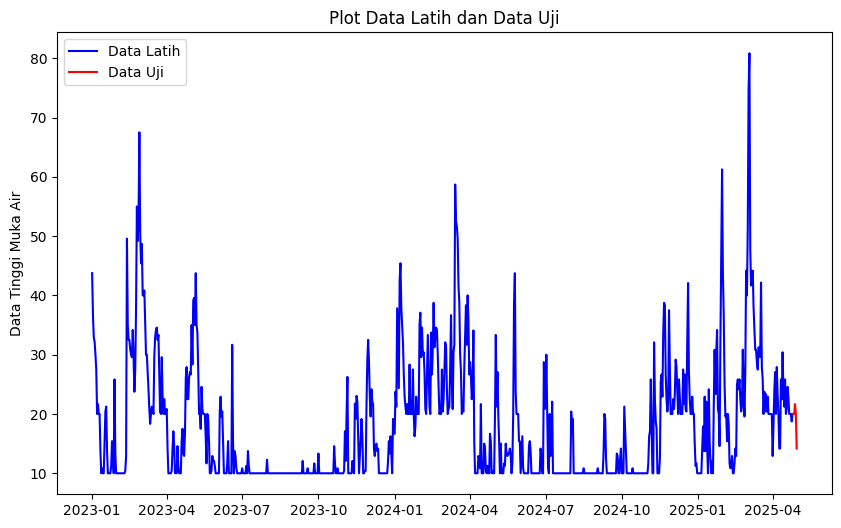

In [3]:
# Memisahkan data menjadi data latih dan data uji
train_data = data.iloc[:846]
test_data = data.iloc[846:]

# Menampilkan jumlah data dalam setiap bagian untuk memastikan pemisahan yang benar
print("Jumlah data latih:", len(train_data))
print("Jumlah data uji:", len(test_data))

# Membuat plot data latih dan data uji
plt.figure(figsize=(10, 6))
plt.plot(train_data['Daily_Period'], train_data['TMA_Daily'], label='Data Latih', color='blue')
plt.plot(test_data['Daily_Period'], test_data['TMA_Daily'], label='Data Uji', color='red')
plt.title('Plot Data Latih dan Data Uji')
plt.ylabel('Data Tinggi Muka Air')
plt.legend()
plt.show()

# LSTM dan Tuning Parameter EPOCH

In [4]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [5]:
# Mengambil kolom 'TMA_Daily' sebagai data yang akan diprediksi
time_series_data = data['TMA_Daily'].values.reshape(-1, 1)

# Normalisasi data ke rentang 0-1
scaler = MinMaxScaler()
time_series_data = scaler.fit_transform(time_series_data)

# Membagi dataset menjadi data latih dan data uji
train_size = 841
test_size = len(time_series_data) - train_size

train_data = time_series_data[:train_size]
test_data = time_series_data[train_size:]

# Fungsi untuk membuat dataset dengan sekuens deret waktu
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

# Panjang sekuens deret waktu (jumlah waktu sebelum prediksi)
seq_length = 5

# Membuat dataset dengan sekuens deret waktu
X_train = create_sequences(train_data, seq_length)
X_test = create_sequences(test_data, seq_length)

# Memisahkan fitur dan target
y_train = X_train[:, -1]
X_train = X_train[:, :-1]
y_test = X_test[:, -1]
X_test = X_test[:, :-1]

# Reshaping data untuk LSTM (jumlah sampel, panjang sekuens, jumlah fitur)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Fungsi untuk membuat model LSTM
def create_model():
    optimizer = Adam(learning_rate=0.005)
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(seq_length - 1, 1))) # Fungsi Aktivasi ReLU
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Fungsi untuk menghitung AIC
def calculate_aic(n, mse, num_params):
    aic = n * np.log(mse) + 2 * num_params
    return aic

# Inisialisasi model
model = create_model()

# List untuk menyimpan nilai AIC pada setiap epoch
aic_values = []

# Jumlah epoch yang akan diuji
epochs_to_test = [10, 50, 100, 150, 200, 250]

# Melatih model sambil menghitung AIC hanya pada epoch yang diinginkan
for epoch in epochs_to_test:
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=16, verbose=0)

    # Prediksi dengan model
    y_pred = model.predict(X_test)

    # Menghitung MSE
    mse = mean_squared_error(y_test, y_pred)

    # Menghitung AIC
    n = len(y_test)
    num_params = len(model.trainable_weights)  # Jumlah parameter model, bisa berbeda tergantung arsitektur
    aic = calculate_aic(n, mse, num_params)

    # Menyimpan nilai AIC
    aic_values.append(aic)
    print(f"Epoch {epoch} - AIC: {aic}")

# Menampilkan nilai AIC per epoch yang diuji
print(aic_values)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Epoch 10 - AIC: -31.372445115921963
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 50 - AIC: -31.911783049869634
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 100 - AIC: -31.865616682805197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 150 - AIC: -33.31086150117458
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Epoch 200 - AIC: -32.720302849154294
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Epoch 250 - AIC: -23.391328263192037
[np.float64(-31.372445115921963), np.float64(-31.911783049869634), np.float64(-31.865616682805197), np.float64(-33.31086150117458), np.float64(-32.720302849154294), np.float64(-23.391328263192037)]


In [6]:
print(X_train)

[[[0.47647059]
  [0.37647059]
  [0.32352941]
  [0.31304348]]

 [[0.37647059]
  [0.32352941]
  [0.31304348]
  [0.28235294]]

 [[0.32352941]
  [0.31304348]
  [0.28235294]
  [0.24705882]]

 ...

 [[0.28823529]
  [0.19411765]
  [0.15882353]
  [0.22352941]]

 [[0.19411765]
  [0.15882353]
  [0.22352941]
  [0.14117647]]

 [[0.15882353]
  [0.22352941]
  [0.14117647]
  [0.15294118]]]


# LSTM Final dengan EPOCH Terbaik

In [7]:
# Membangun model LSTM

# Best Model Skenario
# learning_rate = 0.005
# batch_size = 16

optimizer = Adam(learning_rate=0.005)
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(seq_length - 1, 1)))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss='mse')

# Melatih model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=10)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 7

# Plot Loss pada setiap EPOCH

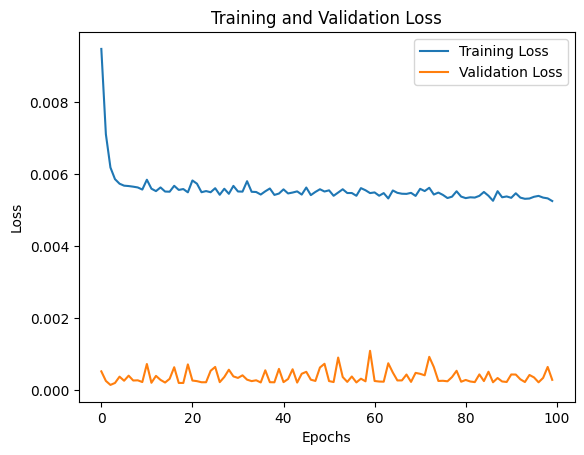

In [8]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Prediksi dengan Model LSTM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


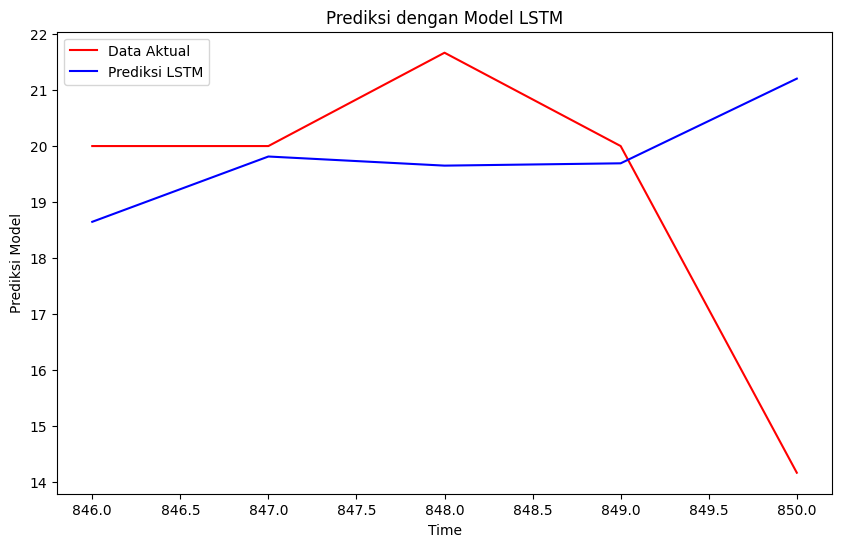

In [9]:
# Membuat prediksi dengan model LSTM
predicted = model.predict(X_test)

# Invers transform hasil prediksi ke skala aslinya
predictLSTM = scaler.inverse_transform(np.concatenate((X_test[:, -1], predicted.reshape(-1, 1)), axis=1))[:, 1]

# Plot hasil prediksi
plt.figure(figsize=(10, 6))
plt.plot(data.index[train_size + seq_length:], data['TMA_Daily'].values[train_size + seq_length:], label='Data Aktual', color='red')
plt.plot(data.index[train_size + seq_length:], predictLSTM, label='Prediksi LSTM', color='blue')
plt.title('Prediksi dengan Model LSTM')
plt.xlabel('Time')
plt.ylabel('Prediksi Model')
plt.legend()
plt.show()

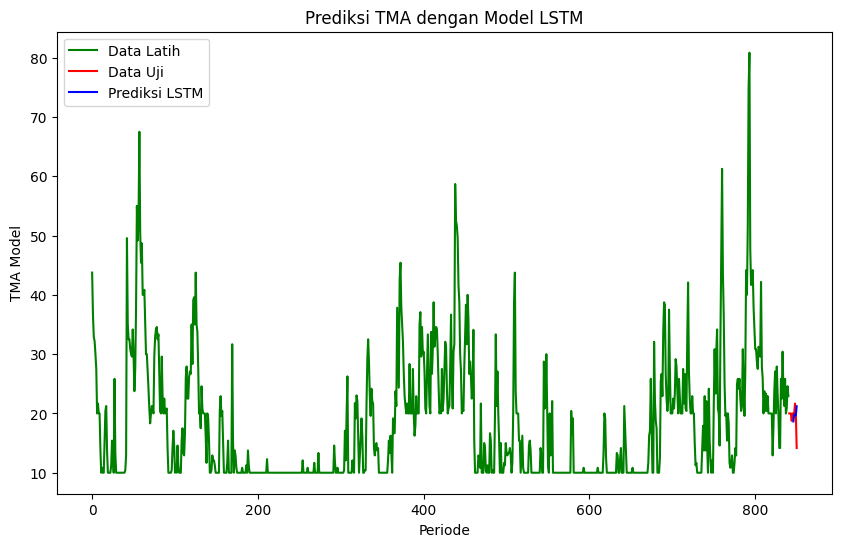

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Plot data latih dan data uji beserta prediksi
plt.figure(figsize=(10, 6))
plt.plot(data.index[:train_size], data['TMA_Daily'].values[:train_size], label='Data Latih', color='green')
plt.plot(data.index[train_size:], data['TMA_Daily'].values[train_size:], label='Data Uji', color='red')
plt.plot(data.index[train_size + seq_length:], predictLSTM, label='Prediksi LSTM', color='blue')
plt.title('Prediksi TMA dengan Model LSTM')
plt.xlabel('Periode')
plt.ylabel('TMA Model')
plt.legend()
plt.show()

In [11]:
# Cek MAPE

from sklearn.metrics import mean_absolute_percentage_error
mapeLSTM = mean_absolute_percentage_error(data['TMA_Daily'].values[train_size + seq_length:], predictLSTM)
print('MAPE:', mapeLSTM)

MAPE: 0.13643564283314027


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

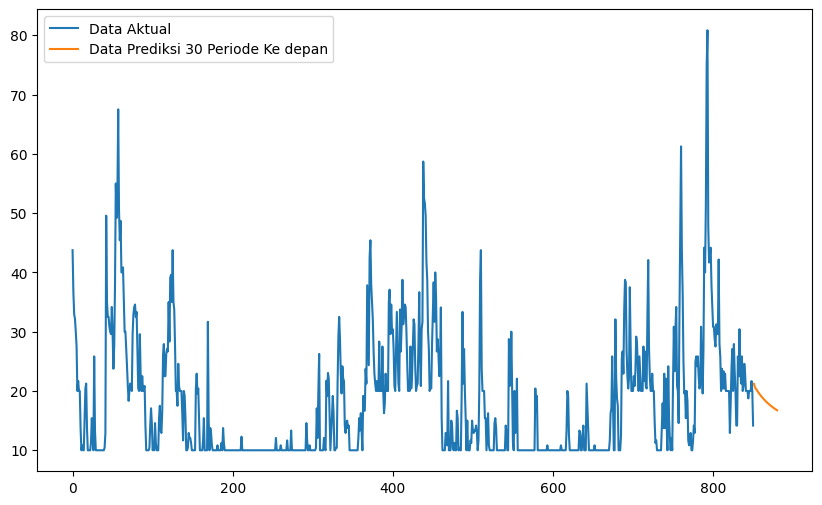

In [12]:
# Menyiapkan data untuk membuat prediksi ke depan
future_steps = 30
future_data = X_test[-1]  # Menggunakan data terakhir dari data uji sebagai awal untuk prediksi ke depan

# Membuat prediksi ke depan
future_predictions = []
for i in range(future_steps):
    prediction = model.predict(future_data.reshape(1, seq_length - 1, 1))
    future_predictions.append(prediction[0, 0])
    future_data = np.append(future_data[1:], prediction[0])  # Memperbarui data untuk prediksi berikutnya

# Invers transform hasil prediksi ke skala aslinya
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Menampilkan hasil prediksi ke depan
print("Prediksi untuk 30 langkah ke depan:", future_predictions)

# Visualisasi hasil prediksi ke depan bersama dengan data asli
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(time_series_data)), scaler.inverse_transform(time_series_data), label='Data Aktual ')
plt.plot(np.arange(len(time_series_data), len(time_series_data) + future_steps), future_predictions, label='Data Prediksi 30 Periode Ke depan')
plt.legend()
plt.show()

In [14]:
future_predictions = pd.DataFrame(future_predictions)
print(future_predictions)

# future_predictions.to_excel("lstm_forecast_futurepred.xlsx", index=False)

            0
0   21.203890
1   20.736893
2   20.453745
3   20.273388
4   20.077503
5   19.872837
6   19.676634
7   19.491915
8   19.315237
9   19.144985
10  18.981033
11  18.823269
12  18.671347
13  18.524893
14  18.383610
15  18.247246
16  18.115561
17  17.988329
18  17.865351
19  17.746433
20  17.631403
21  17.520096
22  17.412363
23  17.308064
24  17.207066
25  17.109247
26  17.014494
27  16.922695
28  16.833752
29  16.747564
